In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import genextreme as ged  # Generalized Error Distribution (GED)


In [ ]:
import yfinance as yahooFinance

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
start = "2004-02-01"
end = '2024-09-08'

In [ ]:
VGT = yahooFinance.download('VGT', start=start, end=end)['Adj Close']
returns_VGT = VGT.pct_change().dropna()
returns_VGT_rescaled = returns_VGT * 100

[*********************100%***********************]  1 of 1 completed


In [ ]:
train_size = int(len(returns_VGT_rescaled) * 0.75)
train_data = returns_VGT_rescaled[:train_size]
test_data = returns_VGT_rescaled[train_size:]

rolling_window = 30

GED TRAIN DATA

In [ ]:
rolling_VaR_95 = []

# rolling VaR based on GED
for i in range(rolling_window, len(train_data)):

    window_data = train_data[i - rolling_window:i]

    # Fit GED distr
    params = ged.fit(window_data)

    #  95th percentile VaR (VaR 5% significance level)
    VaR_95 = ged.ppf(0.05, *params)


    rolling_VaR_95.append(VaR_95)


rolling_VaR_95_df = pd.DataFrame(rolling_VaR_95, index=train_data.index[rolling_window:], columns=['VaR_95'])

rolling_VaR_95_df.head()


,VaR_95
Date,
2004-03-17,-2.485401
2004-03-18,-2.549153
2004-03-19,-2.219535
2004-03-22,-2.262844
2004-03-23,-2.349781


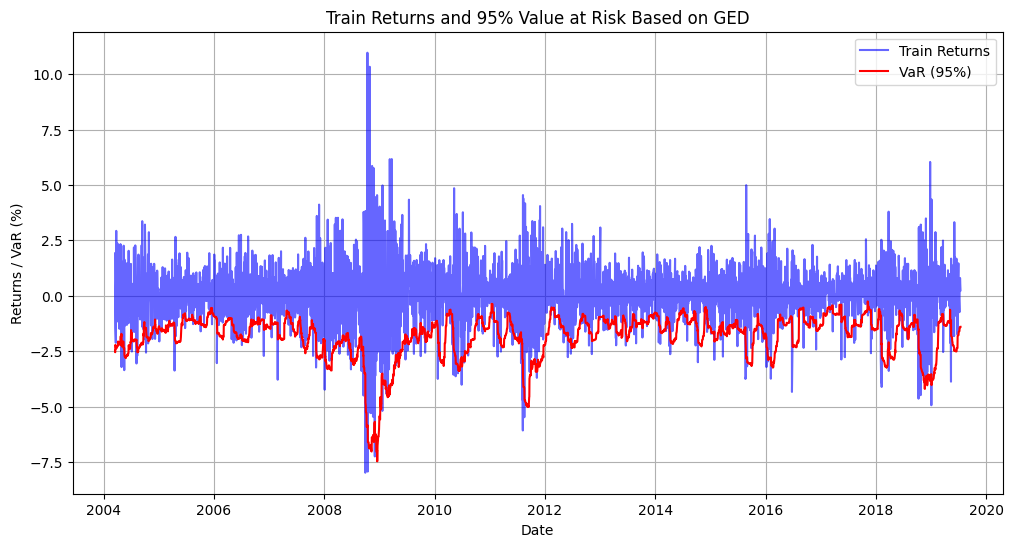

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data[rolling_window:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_95_df, label='VaR (5%)', color='red')
plt.title('Train Returns and 5% Value at Risk Based on GED')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
rolling_ES_95 = []

# Calculate Expected Shortfall based on the previously calculated VaR
for i in range(len(rolling_VaR_95_df)):


    window_data = train_data[i + rolling_window : i + rolling_window + rolling_window]


    VaR_95 = rolling_VaR_95_df.iloc[i, 0]

    # Calculate ES-> mean of returns below the VaR
    ES_95 = window_data[window_data < VaR_95].mean()


    rolling_ES_95.append(ES_95)


rolling_ES_95_df = pd.DataFrame(
    rolling_ES_95,
    index=rolling_VaR_95_df.index,
    columns=['ES_95']
)

rolling_ES_95_df.head()


,ES_95
Date,
2019-07-09,NaN
2019-07-10,NaN
2019-07-11,NaN
2019-07-12,NaN
2019-07-15,NaN


In [ ]:
rolling_ES_95_df.head()

,ES_95
Date,
2004-03-17,NaN
2004-03-18,-3.220189
2004-03-19,-3.220189
2004-03-22,-3.220189
2004-03-23,-3.220189


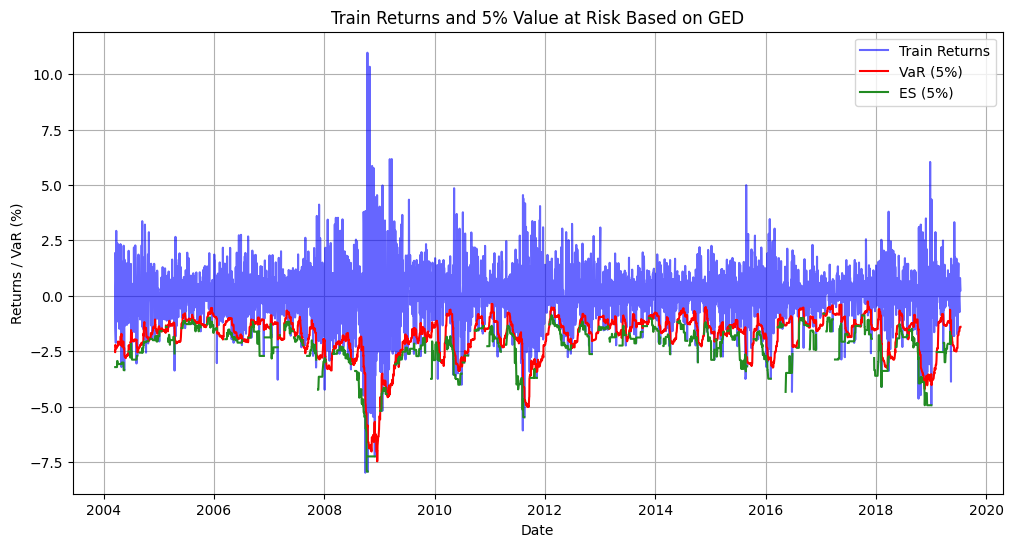

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data[rolling_window:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_95_df, label='VaR (5%)', color='red')
plt.plot(rolling_ES_95_df, label='ES (5%)', color='forestgreen')
plt.title('Train Returns and 5% Value at Risk Based on GED')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
failures_ES_Ged = train_data[rolling_window:][train_data[rolling_window:] < rolling_ES_95_df['ES_95']]

num_failures_ES_Ged = len(failures_ES_Ged)

failure_rate_ES_Ged = (num_failures_ES_Ged / len(rolling_ES_95_df)) * 100

print(f"ES-Ged Failure Rate: {failure_rate_ES_Ged:.2f}%")

ES-Ged Failure Rate: 2.62%


In [ ]:
#  VaR failures
failures = (train_data[rolling_window:] < rolling_VaR_95_df['VaR_95']).sum()

total_observations = len(rolling_VaR_95_df)

# failure rate
failure_rate = (failures / total_observations) * 100

print(f"VaR Failure Rate: {failure_rate:.2f}%")


VaR Failure Rate: 6.84%


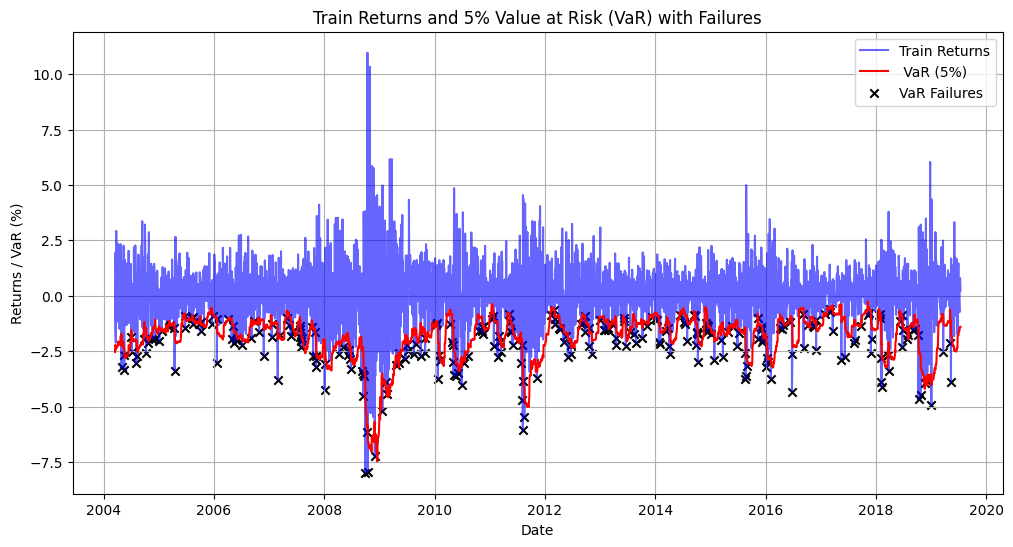

In [ ]:
failures_plot = train_data[rolling_window:][train_data[rolling_window:] < rolling_VaR_95_df['VaR_95']]

plt.figure(figsize=(12, 6))
plt.plot(train_data[rolling_window:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_95_df, label=' VaR (5%)', color='red')
plt.scatter(failures_plot.index, failures_plot, color='black', label='VaR Failures', marker='x')
plt.title('Train Returns and 5% Value at Risk (VaR) with Failures')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

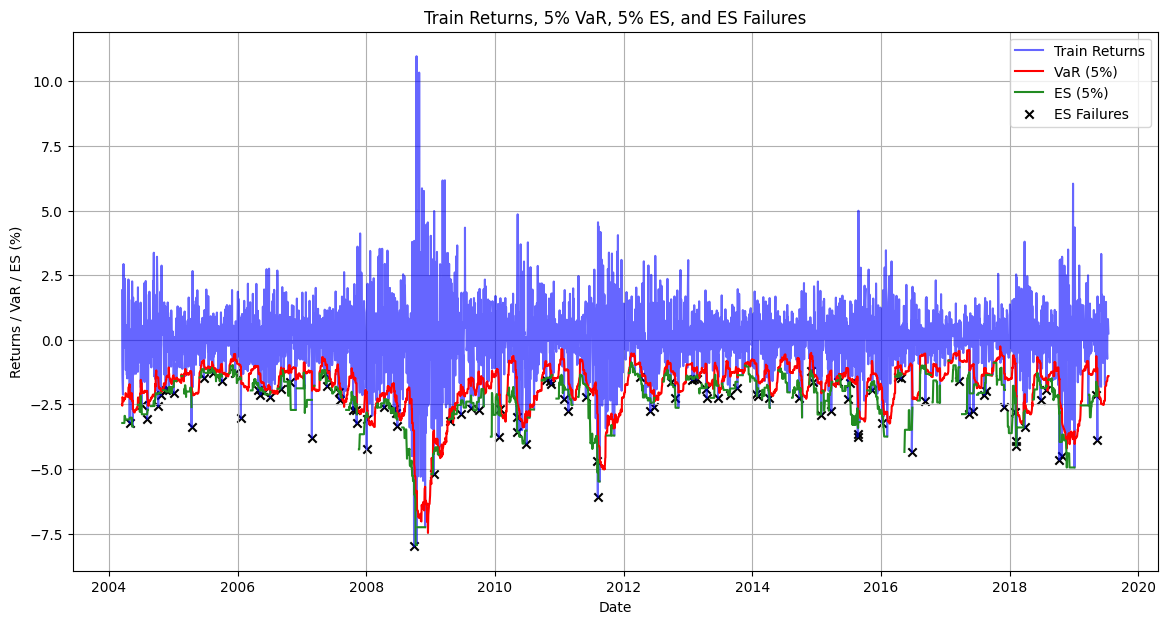

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(train_data[rolling_window:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_95_df, label='VaR (5%)', color='red')
plt.plot(rolling_ES_95_df, label='ES (5%)', color='forestgreen')

# Highlight the failures where returns are below the ES
plt.scatter(failures_ES_Ged.index, failures_ES_Ged, color='black', label='ES Failures', marker='x')

# Add plot details
plt.title('Train Returns, 5% VaR, 5% ES, and ES Failures')
plt.xlabel('Date')
plt.ylabel('Returns / VaR / ES (%)')
plt.legend()
plt.grid()

# Show the plot
plt.show()

VaR Normal distribution

In [ ]:
rolling_window_normal = 30  # Same as before


rolling_VaR_normal_95 = []

#rolling normal VaR
for i in range(rolling_window_normal, len(train_data)):

    window_data = train_data[i - rolling_window_normal:i]

    # Calculate the 5% VaR using the normal distribution assumption
    VaR_normal_95 = np.percentile(window_data, 5)


    rolling_VaR_normal_95.append(VaR_normal_95)


rolling_VaR_normal_95_df = pd.DataFrame(rolling_VaR_normal_95, index=train_data.index[rolling_window_normal:], columns=['VaR_Normal_95'])


rolling_VaR_normal_95_df.head()

,VaR_Normal_95
Date,
2004-03-17,-2.519824
2004-03-18,-2.519824
2004-03-19,-2.041589
2004-03-22,-2.041589
2004-03-23,-2.119646


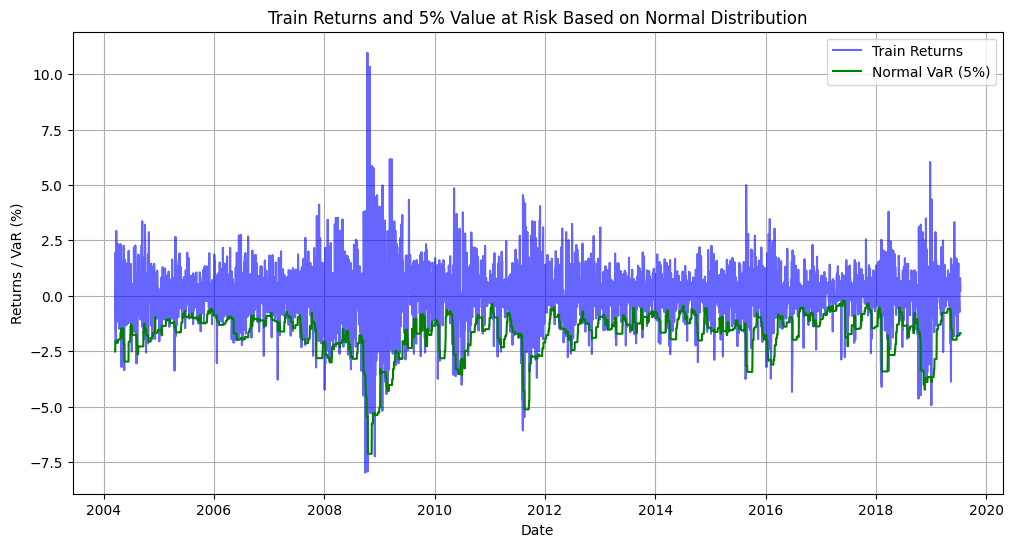

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data[rolling_window:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_normal_95_df, label='Normal VaR (5%)', color='green')
plt.title('Train Returns and 5% Value at Risk Based on Normal Distribution')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()


In [ ]:

failures_normal = (train_data[rolling_window:] < rolling_VaR_normal_95_df['VaR_Normal_95']).sum()
failure_rate_normal = (failures_normal / len(rolling_VaR_normal_95_df)) * 100

print(f"Normal VaR Failure Rate: {failure_rate_normal:.2f}%")

Normal VaR Failure Rate: 7.85%


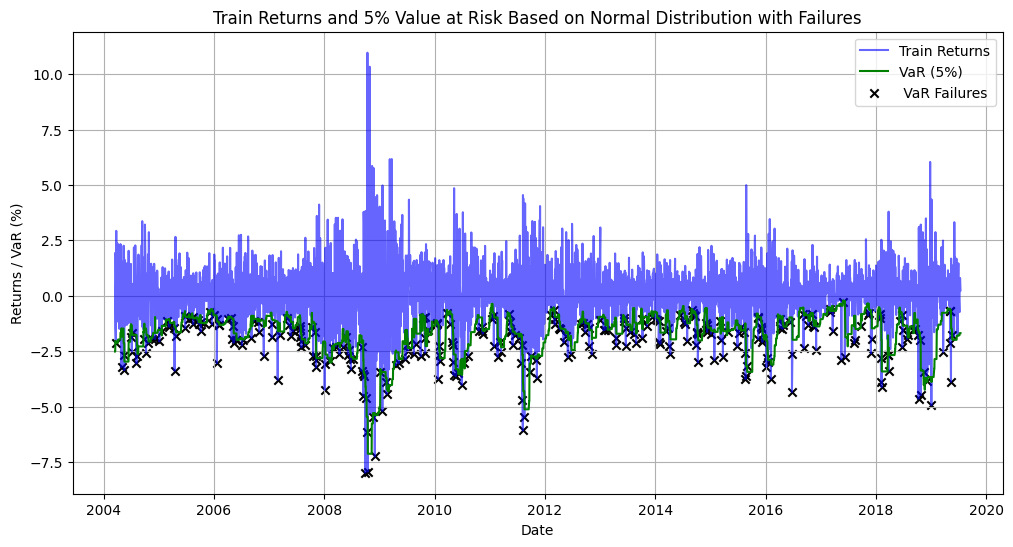

In [ ]:

failures_normal_plot = train_data[rolling_window:][train_data[rolling_window:] < rolling_VaR_normal_95_df['VaR_Normal_95']]

plt.figure(figsize=(12, 6))
plt.plot(train_data[rolling_window:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_normal_95_df, label='VaR (5%)', color='green')
plt.scatter(failures_normal_plot.index, failures_normal_plot, color='black', label=' VaR Failures', marker='x')
plt.title('Train Returns and 5% Value at Risk Based on Normal Distribution with Failures')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()


Skew-t VaR

In [ ]:
from scipy.stats import t, skewnorm

In [ ]:
rolling_window_skewt = 30

rolling_VaR_skewt_95 = []

# rolling Skewed t VaR
for i in range(rolling_window_skewt, len(train_data)):

    window_data = train_data[i - rolling_window_skewt:i]

    # Fit the Skewed t-distribution
    params = skewnorm.fit(window_data)

    # Calculate the 5% VaR using the fitted parameters
    VaR_skewt_95 = skewnorm.ppf(0.05, *params)


    rolling_VaR_skewt_95.append(VaR_skewt_95)


rolling_VaR_skewt_95_df = pd.DataFrame(rolling_VaR_skewt_95, index=train_data.index[rolling_window_skewt:], columns=['VaR_SkewT_95'])



In [ ]:
rolling_ES_skewt_95 = []

# Calculate Expected Shortfall based on the previously calculated VaR
for i in range(len(rolling_VaR_skewt_95_df)):


    window_data = train_data[i + rolling_window : i + rolling_window + rolling_window]


    VaR_skewt_95 = rolling_VaR_skewt_95_df.iloc[i, 0]

    # Calculate ES-> mean of returns below the VaR
    ES_skewt_95 = window_data[window_data < VaR_skewt_95].mean()


    rolling_ES_skewt_95.append(ES_skewt_95)


rolling_ES_skewt_95_df = pd.DataFrame(
    rolling_ES_skewt_95,
    index=rolling_VaR_skewt_95_df.index,
    columns=['ES_skewt_95']
)

rolling_ES_skewt_95_df.head()


,ES_skewt_95
Date,
2004-03-17,NaN
2004-03-18,-3.220189
2004-03-19,-3.220189
2004-03-22,-3.220189
2004-03-23,-3.220189


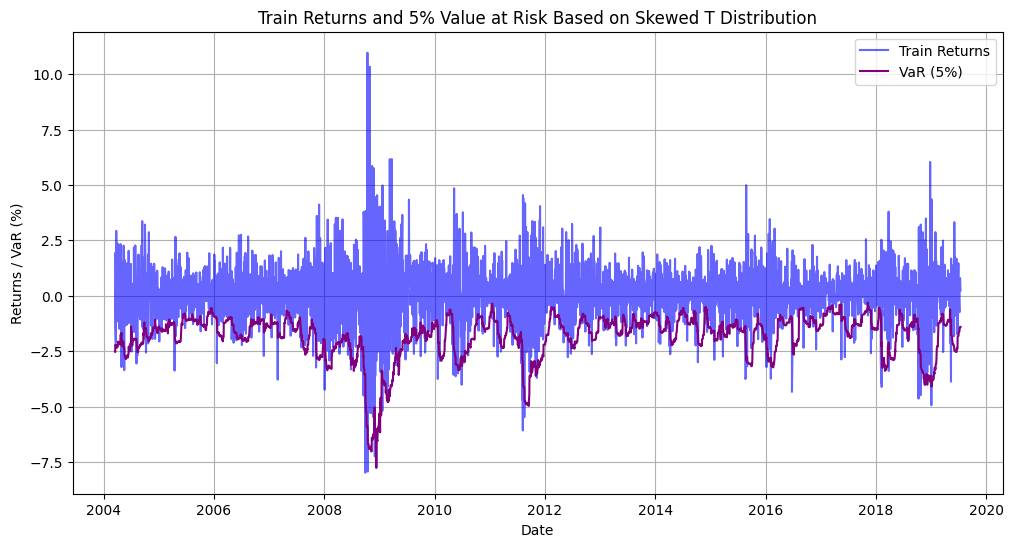

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data[rolling_window_skewt:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_skewt_95_df, label='VaR (5%)', color='purple')
plt.title('Train Returns and 5% Value at Risk Based on Skewed T Distribution')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

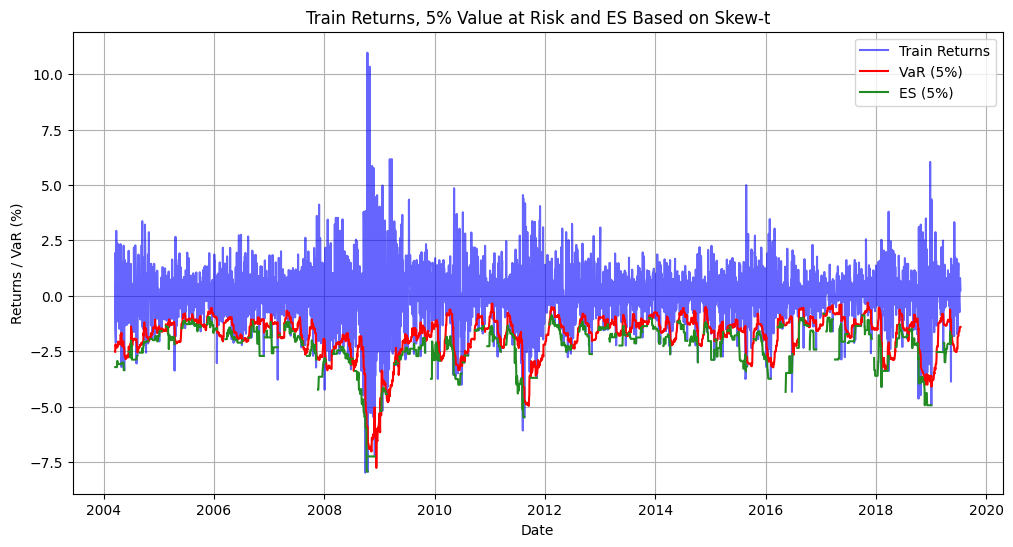

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data[rolling_window:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_skewt_95_df, label='VaR (5%)', color='red')
plt.plot(rolling_ES_skewt_95_df, label='ES (5%)', color='forestgreen')
plt.title('Train Returns, 5% Value at Risk and ES Based on Skew-t')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

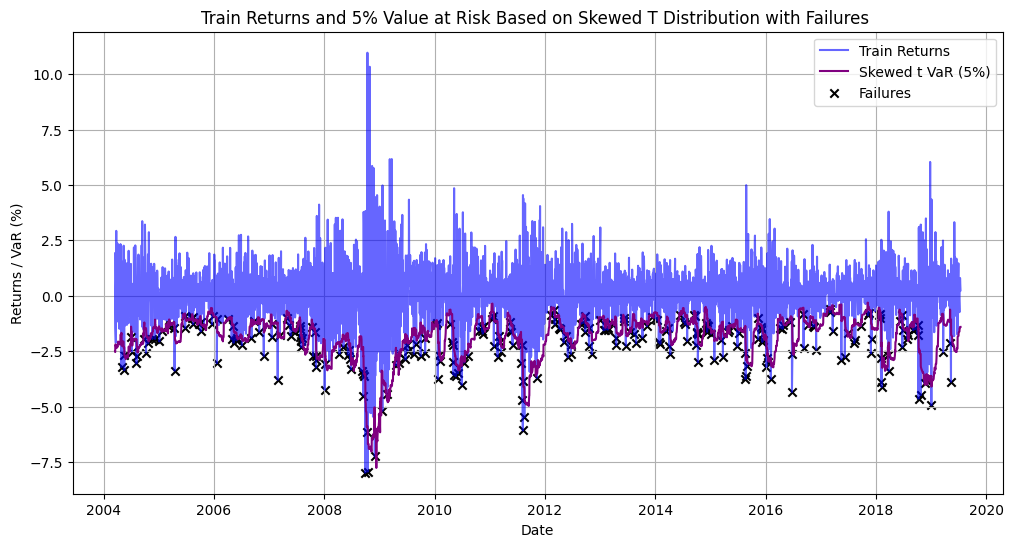

In [ ]:
failures_skewt = train_data[rolling_window_skewt:][train_data[rolling_window_skewt:] < rolling_VaR_skewt_95_df['VaR_SkewT_95']]

plt.figure(figsize=(12, 6))
plt.plot(train_data[rolling_window_skewt:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_skewt_95_df, label='Skewed t VaR (5%)', color='purple')
plt.scatter(failures_skewt.index, failures_skewt, color='black', label='Failures', marker='x')
plt.title('Train Returns and 5% Value at Risk Based on Skewed T Distribution with Failures ')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
failures_skewt_count = (train_data[rolling_window_skewt:] < rolling_VaR_skewt_95_df['VaR_SkewT_95']).sum()
failure_rate_skewt = (failures_skewt_count / len(rolling_VaR_skewt_95_df)) * 100

print(f"Skewed t VaR Failure Rate: {failure_rate_skewt:.2f}%")

Skewed t VaR Failure Rate: 6.82%


In [ ]:
failures_ES_skewt = train_data[rolling_window:][train_data[rolling_window:] < rolling_ES_skewt_95_df['ES_skewt_95']]

num_failures_ES_skewt = len(failures_ES_skewt)

failure_rate_ES_skewt = (num_failures_ES_skewt / len(rolling_ES_skewt_95_df)) * 100

print(f"ES-Skewt Failure Rate: {failure_rate_ES_skewt:.2f}%")


ES-Skewt Failure Rate: 2.67%


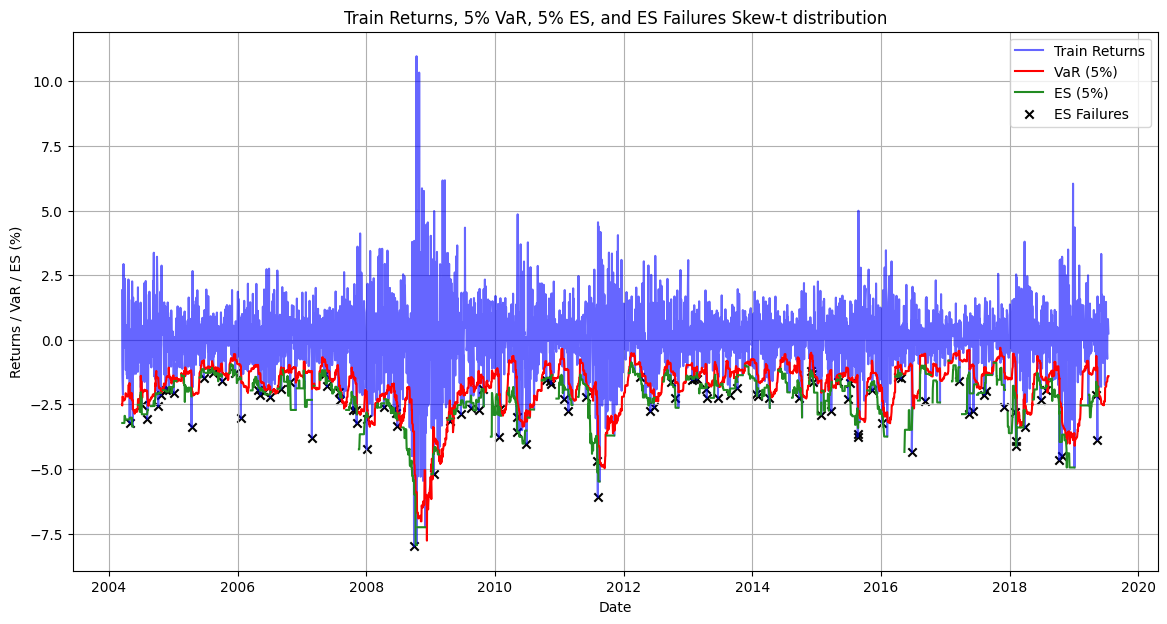

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(train_data[rolling_window:], label='Train Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_skewt_95_df, label='VaR (5%)', color='red')
plt.plot(rolling_ES_skewt_95_df, label='ES (5%)', color='forestgreen')


plt.scatter(failures_ES_skewt.index, failures_ES_skewt, color='black', label='ES Failures', marker='x')


plt.title('Train Returns, 5% VaR, 5% ES, and ES Failures Skew-t distribution')
plt.xlabel('Date')
plt.ylabel('Returns / VaR / ES (%)')
plt.legend()
plt.grid()

plt.show()

Test forecasting on GED

In [ ]:
rolling_VaR_95_test = []


for i in range(len(test_data)):
    if i < rolling_window:

        rolling_VaR_95_test.append(np.nan)
    else:

        window_data = test_data[i - rolling_window:i]


        params = ged.fit(window_data)


        VaR_95 = ged.ppf(0.05, *params)


        rolling_VaR_95_test.append(VaR_95)


rolling_VaR_95_test_df = pd.DataFrame(
    rolling_VaR_95_test,
    index=test_data.index,
    columns=['VaR_95']
)

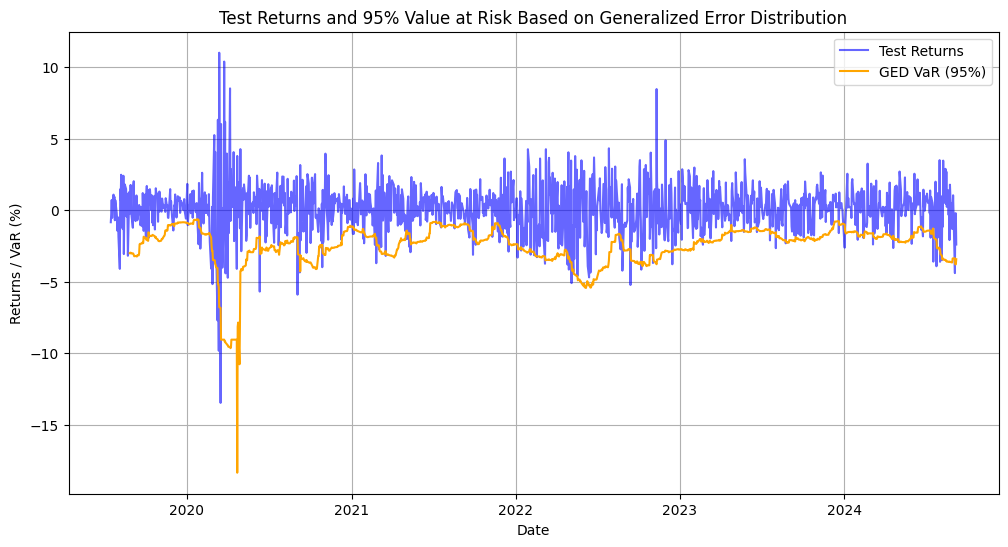

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_95_test_df, label='GED VaR (5%)', color='orange')
plt.title('Test Returns and 5% Value at Risk Based on Generalized Error Distribution')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

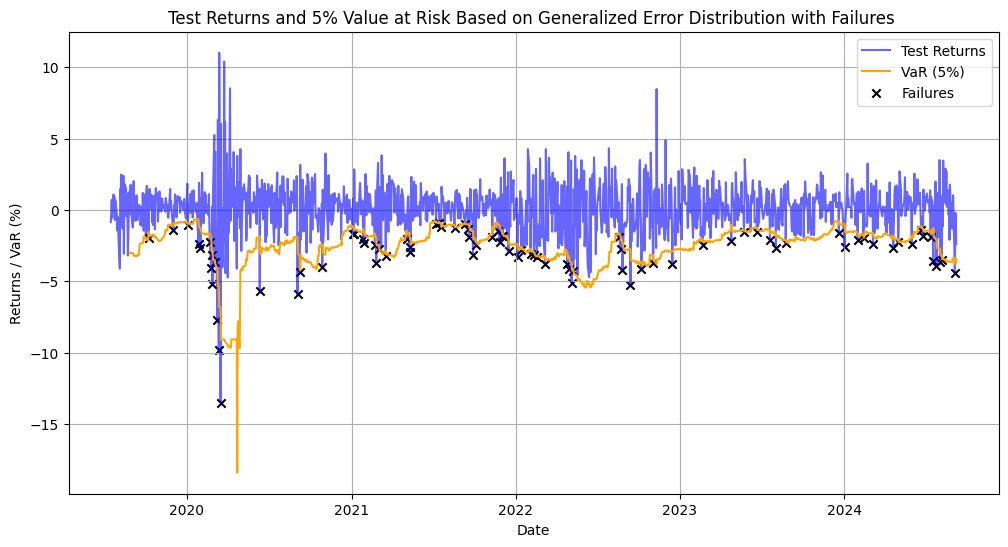

In [ ]:
failures_ged_test = test_data[rolling_window:][test_data[rolling_window:] < rolling_VaR_95_test_df['VaR_95'][rolling_window:]]

# Plot the returns, GED VaR, failures
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_95_test_df, label='VaR (5%)', color='orange')
plt.scatter(failures_ged_test.index, failures_ged_test, color='black', label='Failures', marker='x')
plt.title('Test Returns and 5% Value at Risk Based on Generalized Error Distribution with Failures ')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
failures_ged_test_count = (test_data[rolling_window:] < rolling_VaR_95_test_df['VaR_95'][rolling_window:]).sum()
failure_rate_ged_test = (failures_ged_test_count / len(rolling_VaR_95_test_df[rolling_window:])) * 100

print(f"GED VaR Failure Rate on Test Data: {failure_rate_ged_test:.2f}%")

GED VaR Failure Rate on Test Data: 6.56%


In [ ]:
rolling_ES_95_test = []

# Calculate the rolling Expected Shortfall based on the forecasted VaR for the test data
for i in range(len(rolling_VaR_95_test_df)):
    # Get the current rolling window of test data
    if i < rolling_window:
        rolling_ES_95_test.append(np.nan)
    else:
        window_data = test_data[i - rolling_window:i]
        VaR_95 = rolling_VaR_95_test_df.iloc[i, 0]

        # Calculate the Expected Shortfall (ES) as the mean of returns below the VaR
        ES_95 = window_data[window_data < VaR_95].mean()
        rolling_ES_95_test.append(ES_95)


rolling_ES_95_test_df = pd.DataFrame(
    rolling_ES_95_test,
    index=test_data.index,
    columns=['ES_95']
)


In [ ]:
rolling_ES_95_test_df.tail()

,ES_95
Date,
2024-08-30,-3.679762
2024-09-03,-3.679762
2024-09-04,-4.164817
2024-09-05,-4.164817
2024-09-06,-3.839485


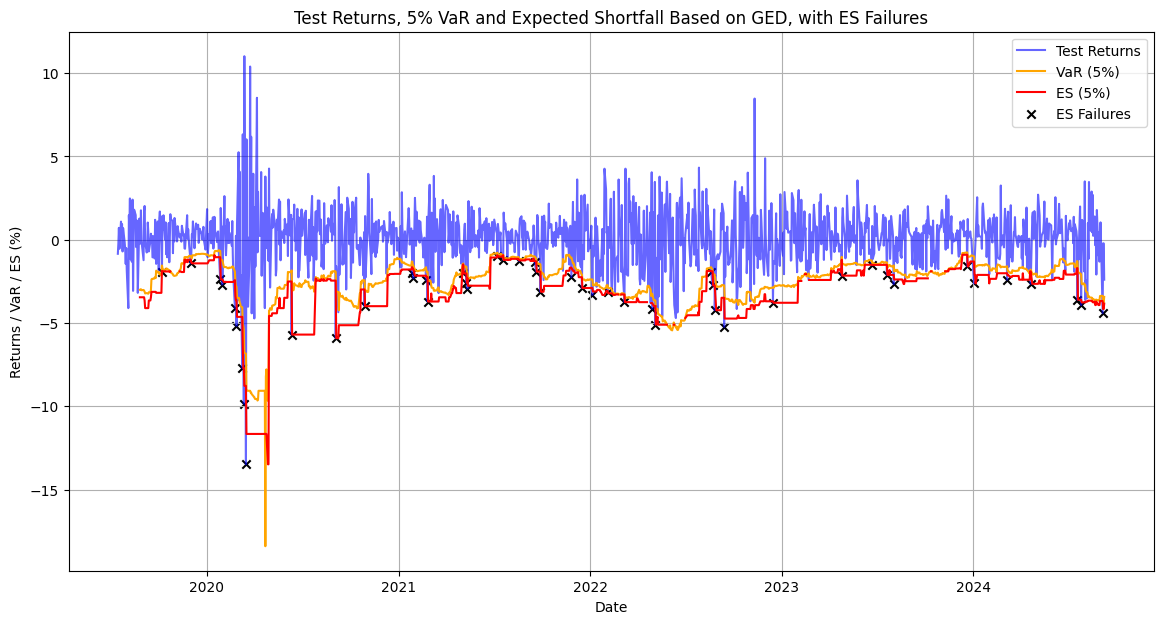

In [ ]:
# Identify failures where the actual returns fall below the ES
failures_ES_test = test_data[rolling_window:][test_data[rolling_window:] < rolling_ES_95_test_df['ES_95'][rolling_window:]]

# Plot the returns, GED VaR, ES, and failures
plt.figure(figsize=(14, 7))
plt.plot(test_data, label='Test Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_95_test_df, label='VaR (5%)', color='orange')
plt.plot(rolling_ES_95_test_df, label='ES (5%)', color='red')
plt.scatter(failures_ES_test.index, failures_ES_test, color='black', label='ES Failures', marker='x')
plt.title('Test Returns, 5% VaR and Expected Shortfall Based on GED, with ES Failures')
plt.xlabel('Date')
plt.ylabel('Returns / VaR / ES (%)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
failures_ES_test_count = (test_data[rolling_window:] < rolling_ES_95_test_df['ES_95'][rolling_window:]).sum()
failure_rate_ES_test = (failures_ES_test_count / len(rolling_ES_95_test_df[rolling_window:])) * 100

print(f"GED ES Failure Rate on Test Data: {failure_rate_ES_test:.2f}%")

GED ES Failure Rate on Test Data: 3.79%


Skew-T forecasting

In [ ]:
rolling_VaR_skewt_95_train = []

# Skewed t VaR for the training data
for i in range(rolling_window, len(train_data)):
    window_data = train_data[i - rolling_window:i]

    # Fit
    params = skewnorm.fit(window_data)

    # 5% VaR with fitted parameters
    VaR_skewt_95 = skewnorm.ppf(0.05, *params)

    rolling_VaR_skewt_95_train.append(VaR_skewt_95)

rolling_VaR_skewt_95_train_df = pd.DataFrame(
    rolling_VaR_skewt_95_train,
    index=train_data.index[rolling_window:],
    columns=['VaR_SkewT_95']
)

# Step 2: Forecast Rolling Skew-t VaR for the Test Data
rolling_VaR_skewt_95_test = []

# Rolling Skewed t VaR for the test data
for i in range(len(test_data)):
    if i < rolling_window:
        rolling_VaR_skewt_95_test.append(np.nan)
    else:
        # Get the current rolling window of test data
        window_data = test_data[i - rolling_window:i]

        # Fit the Skewed t-distribution to the rolling window of test data
        params = skewnorm.fit(window_data)

        # Calculate the 5% VaR using the fitted parameters
        VaR_skewt_95_test = skewnorm.ppf(0.05, *params)

        # Append the calculated VaR to the list
        rolling_VaR_skewt_95_test.append(VaR_skewt_95_test)

# Convert list to a DataFrame
rolling_VaR_skewt_95_test_df = pd.DataFrame(
    rolling_VaR_skewt_95_test,
    index=test_data.index,
    columns=['VaR_SkewT_Test_95']
)


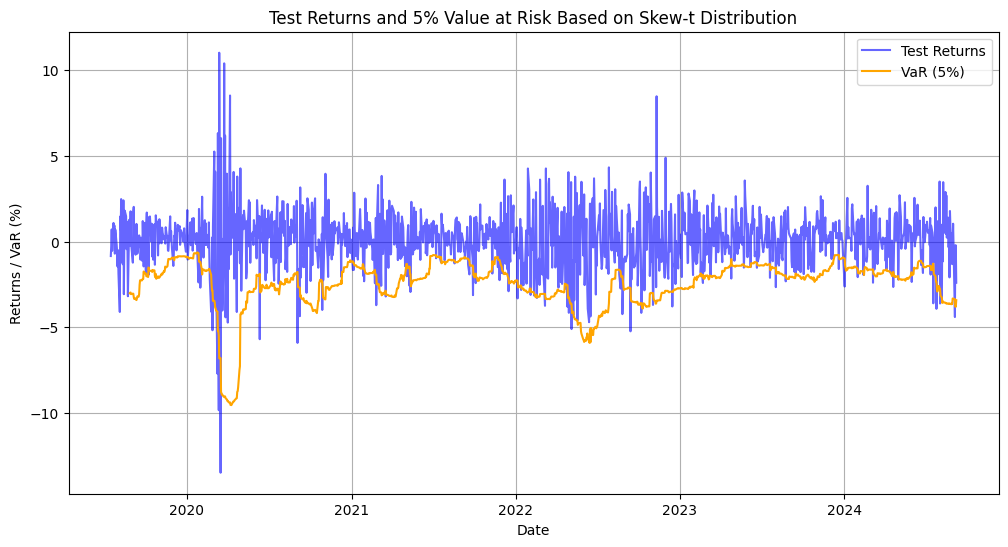

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_skewt_95_test_df, label='VaR (5%)', color='orange')
plt.title('Test Returns and 5% Value at Risk Based on Skew-t Distribution')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

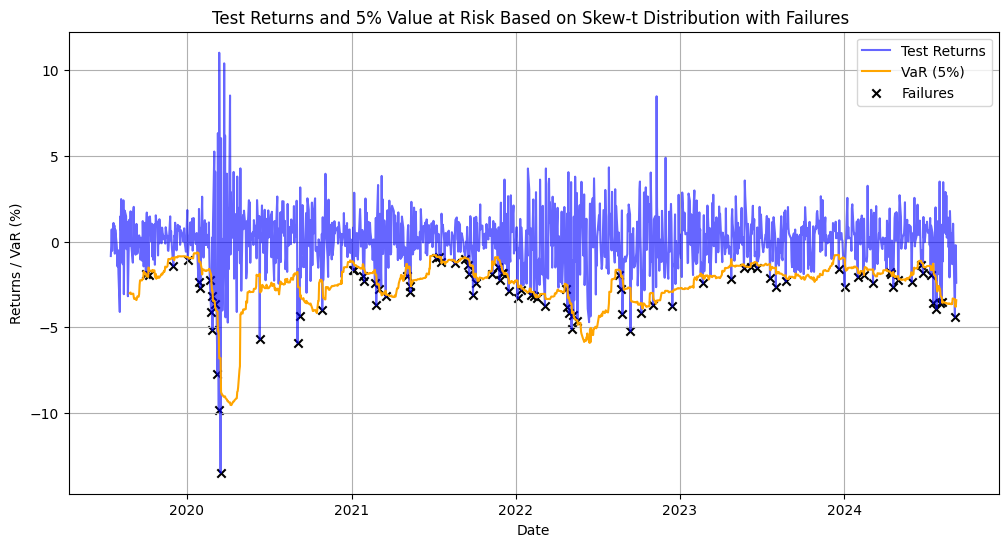

In [ ]:
failures_skewt_test = test_data[rolling_window:][test_data[rolling_window:] < rolling_VaR_skewt_95_test_df['VaR_SkewT_Test_95'][rolling_window:]]

# Plot the returns, Skew-t VaR, and highlight the failures
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_skewt_95_test_df, label='VaR (5%)', color='orange')
plt.scatter(failures_skewt_test.index, failures_skewt_test, color='black', label='Failures', marker='x')
plt.title('Test Returns and 5% Value at Risk Based on Skew-t Distribution with Failures ')
plt.xlabel('Date')
plt.ylabel('Returns / VaR (%)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
failures_skewt_test_count = (test_data[rolling_window:] < rolling_VaR_skewt_95_test_df['VaR_SkewT_Test_95'][rolling_window:]).sum()
failure_rate_skewt_test = (failures_skewt_test_count / len(rolling_VaR_skewt_95_test_df[rolling_window:])) * 100

print(f"Skew-t VaR Failure Rate on Test Data: {failure_rate_skewt_test:.2f}%")

Skew-t VaR Failure Rate on Test Data: 7.03%


In [ ]:
rolling_ES_skewt_95_test = []

# Calculate the rolling Expected Shortfall based on the forecasted Skew-t VaR for the test data
for i in range(len(rolling_VaR_skewt_95_test_df)):
    if i < rolling_window:
        rolling_ES_skewt_95_test.append(np.nan)
    else:
        # Get the current rolling window of test data
        window_data = test_data[i - rolling_window:i]
        VaR_skewt_95_test = rolling_VaR_skewt_95_test_df.iloc[i, 0]

        # Calculate the Expected Shortfall (ES) as the mean of returns below the VaR
        ES_skewt_95 = window_data[window_data < VaR_skewt_95_test].mean()
        rolling_ES_skewt_95_test.append(ES_skewt_95)

# Convert the rolling ES list to a DataFrame for the test data
rolling_ES_skewt_95_test_df = pd.DataFrame(
    rolling_ES_skewt_95_test,
    index=test_data.index,
    columns=['ES_SkewT_95']
)

In [ ]:
rolling_ES_skewt_95_test_df.tail()

,ES_SkewT_95
Date,
2024-08-30,-3.679762
2024-09-03,-3.679762
2024-09-04,-4.164817
2024-09-05,-4.164817
2024-09-06,-3.839485


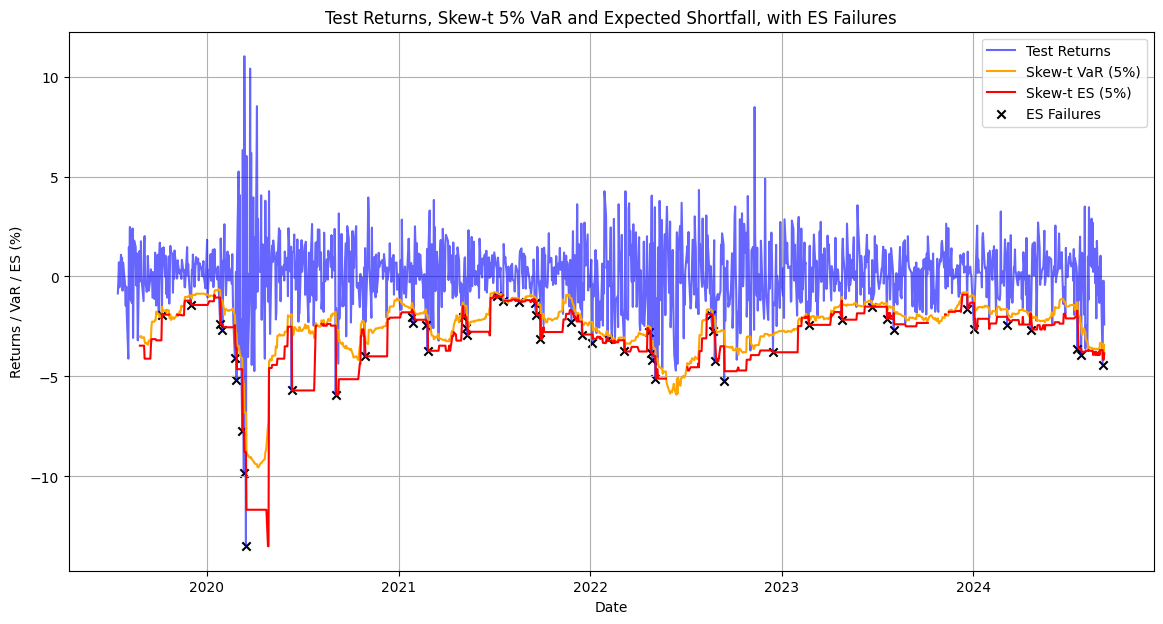

In [ ]:
failures_ES_skewt_test = test_data[rolling_window:][test_data[rolling_window:] < rolling_ES_skewt_95_test_df['ES_SkewT_95'][rolling_window:]]

# Plot the test returns, Skew-t VaR, ES, and ES failures
plt.figure(figsize=(14, 7))
plt.plot(test_data, label='Test Returns', color='blue', alpha=0.6)
plt.plot(rolling_VaR_skewt_95_test_df, label='Skew-t VaR (5%)', color='orange')
plt.plot(rolling_ES_skewt_95_test_df, label='Skew-t ES (5%)', color='red')
plt.scatter(failures_ES_skewt_test.index, failures_ES_skewt_test, color='black', label='ES Failures', marker='x')
plt.title('Test Returns, Skew-t 5% VaR and Expected Shortfall, with ES Failures')
plt.xlabel('Date')
plt.ylabel('Returns / VaR / ES (%)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
failures_ES_skewt_test_count = (test_data[rolling_window:] < rolling_ES_skewt_95_test_df['ES_SkewT_95'][rolling_window:]).sum()
failure_rate_ES_skewt_test = (failures_ES_skewt_test_count / len(rolling_ES_skewt_95_test_df[rolling_window:])) * 100

print(f"Skew-t ES Failure Rate on Test Data: {failure_rate_ES_skewt_test:.2f}%")

Skew-t ES Failure Rate on Test Data: 4.03%


summary Train data  VaR

In [ ]:
print(f"VaR Failure Rate: {failure_rate:.2f}%")
print(f"Normal VaR Failure Rate: {failure_rate_normal:.2f}%")
print(f"Skewed t VaR Failure Rate: {failure_rate_skewt:.2f}%")

VaR Failure Rate: 6.84%
Normal VaR Failure Rate: 7.85%
Skewed t VaR Failure Rate: 6.82%


summary train data ES

In [ ]:
print(f"ES-Ged Failure Rate: {failure_rate_ES_Ged:.2f}%")
print(f"ES-Skewt Failure Rate: {failure_rate_ES_skewt:.2f}%")

ES-Ged Failure Rate: 2.62%
ES-Skewt Failure Rate: 2.67%


summary test data VaR

In [ ]:
print(f"GED VaR Failure Rate on Test Data: {failure_rate_ged_test:.2f}%")
print(f"Skew-t VaR Failure Rate on Test Data: {failure_rate_skewt_test:.2f}%")

GED VaR Failure Rate on Test Data: 6.56%
Skew-t VaR Failure Rate on Test Data: 7.03%


summary test data ES

In [ ]:
print(f"GED ES Failure Rate on Test Data: {failure_rate_ES_test:.2f}%")
print(f"Skew-t ES Failure Rate on Test Data: {failure_rate_ES_skewt_test:.2f}%")

GED ES Failure Rate on Test Data: 3.79%
Skew-t ES Failure Rate on Test Data: 4.03%
